# Mean Force Integration

The aim of this notebook is to provide examples, as how to run metadynamics simulations, analyse them with MFI and use other useful features.
The layout of this notebook is as follows:

A: Simulations on Alanine Dipeptide

    (1) - Analysing a metadynamics simulations with MFI
    (2) - Running a new simulation and patching (1) and (2) together
    (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together 

B: Simulations on Bjola Potential

    (1) - Running a metadynamics simulation and analyse with MFI
    (2) - Running 10 short simulations (each 1/10 the length of (1), and patch togehter with MFI)
    (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together

C: Simulations on Invernizzi Potential

    (1) - Running a metadynamics simulation and analyse with MFI
    (2) - Running 20 short simulations, patch togehter with MFI, and determine bootstrap error
    (3) - Take first 10 simulations from (2) and run 10 short simulations with MetaD and HP. 
          Patch together and determine bootstrap error. 


In [1]:
import os
if 'path' in locals() or 'path' in globals(): os.chdir(path)
else: path = os.getcwd()
print("The path to this notebook is:", path)
path_MFI = os.path.dirname(path) + "/"
print("The path to the MFI forder is:", path_MFI)

import numpy as np
import sys
sys.path.insert(0, path_MFI)
from pyMFI import MFI
from pyMFI import run_plumed
import pickle
import matplotlib.pyplot as plt

path_AP = path_MFI + "DATA_examples/AlanineDipeptide_pyMFI"
path_4W = path_MFI + "DATA_examples/Antoniu_2D_potential"
path_inve = path_MFI + "DATA_examples/Invernizzi_2D_potential"

The path to this notebook is: /home/ucecabj/Desktop/MFI_git/Notebooks
The path to the MFI forder is: /home/ucecabj/Desktop/MFI_git/


## A: Alanine Dipeptide | 2D periodic CV space example.

#### (1) - Analysing an existing metadynamics simulations with MFI.

A metadynaics simulation was already conducted. The resulting trajectory as CV's coordinates are saved in the file "positon_1sim" and the corresponding HILLS file is saved as "HILLS_1sim".

In [2]:
### ~~~ Run new simulation ~~~ ###
os.chdir(path_AP)
# simulation_steps = 300000

# #prepare new input files
# run_plumed.find_alanine_dipeptide_input(initial_position_x=0.0, initial_position_y=0.0, file_extension="_1sim")

# #Run Alanine dipeptide simulation
# run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=3, biasfactor=20, gaus_pace=100, file_extension="_1sim")

|**************************************************| 100% | Average Mean Force Error: 6.813

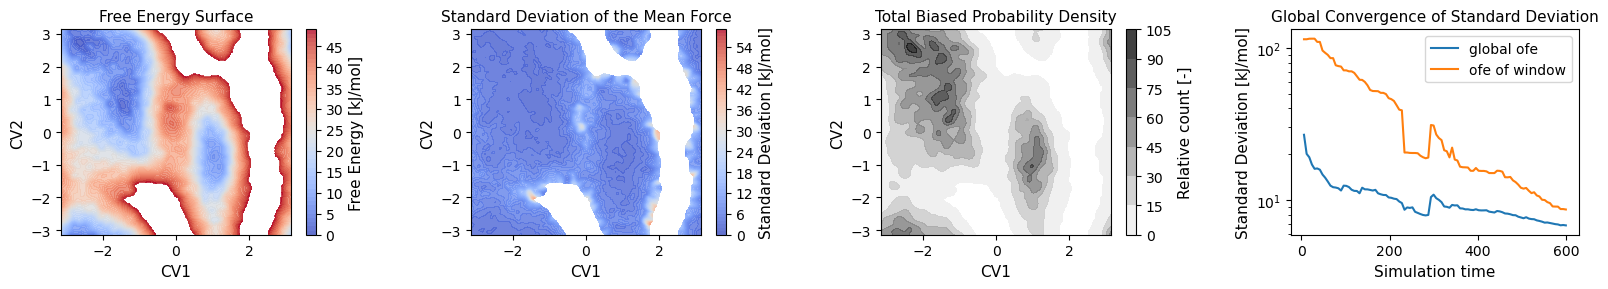

In [9]:
os.chdir(path_AP)

# Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_1sim")

# Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_1sim")

# #Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], kT = 2.49, error_pace = int(len(HILLS)/100), 
                     WellTempered=1, nhills=-1, periodic = [1,1], window_corners=[-0.5, 0.5, -1.5, 1.5], FES_cutoff=50, use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

# #integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, periodic=np.array((1,1)))

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history, time_history, FES_lim=50, ofe_map_lim=60)

plt.plot(time_history, ofe_history_window, label="ofe of window")
plt.legend()
plt.show()

#rename results for later use
Force_terms_old = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]
ofe_history_old, ofe_history_window_old, time_history_old = ofe_history, ofe_history_window, time_history

#### (2) - Running a new simulation and patching (1) and (2) together

Requires that simulation (1) has already been analysed and the force terms and error progression to be saved in the Force_terms_old and ofe_history_old list.

In [5]:
### ~~~ Run new simulation ~~~ ###
# simulation_steps = 300000  #simulations steps for new simulation, same as before.

# #prepare new input files
# run_plumed.find_alanine_dipeptide_input(initial_position_x=1.0, initial_position_y=-1.0, file_extension="_2sim")

# #Run Alanine dipeptide simulation
# run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=3, biasfactor=20, gaus_pace=100, file_extension="_2sim")

|**************************************************| 100% | Average Mean Force Error: 5.831

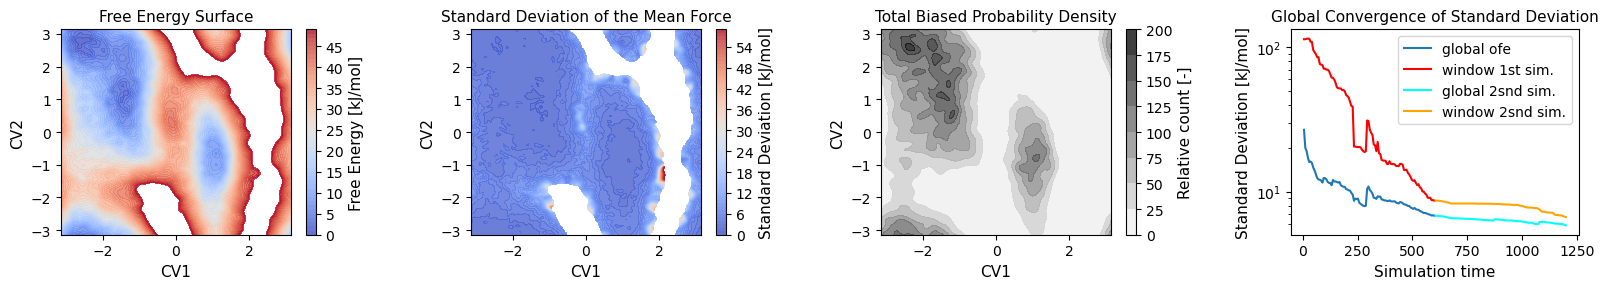

In [10]:
#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_2sim")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_2sim")

# Compute the time-independent mean forcefro
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], kT = 2.49, periodic = [1,1], error_pace = int(len(HILLS)/100), 
                     WellTempered=1, nhills=-1, window_corners=[-0.5, 0.5, -1.5, 1.5], FES_cutoff=50, base_terms = Force_terms_old, use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

#Patch results
patch = MFI.patch_2D([Force_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]])
time_history = [element+time_history_old[-1] for element in time_history]


#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(patch[2], patch[3], periodic = np.array((1,1)))

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, patch[0], ofe, ofe_history_old, time_history_old, FES_lim=50, ofe_map_lim=60)
# plt.plot(0, np.nan, c="C0", label="1st sim.")
plt.plot(time_history_old, ofe_history_window_old, c="red", label="window 1st sim.")
plt.plot(time_history, ofe_history, c="cyan", label="global 2snd sim.")
plt.plot(time_history, ofe_history_window, c="orange", label="window 2snd sim.")
# plt.ylim(25,70); 
plt.legend() 
plt.show()

#### (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together

Requires that simulation (1) has already been analysed and the force terms and error progression to be saved in the Force_terms_old and ofe_history_old list.



|**************************************************| 100% | Average Mean Force Error: 5.758

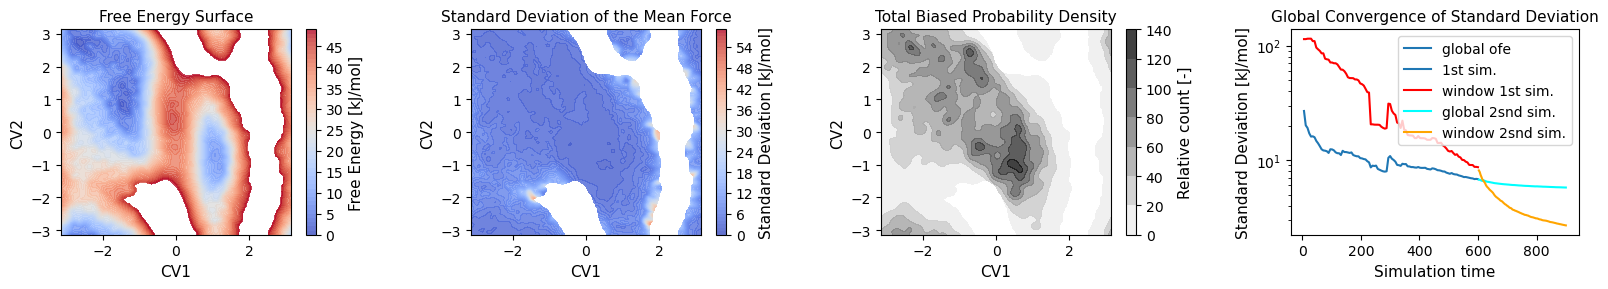

In [8]:
### ~~~ Run new simulation ~~~ ###
os.chdir(path_AP)
kappa = [100, 0]; hp_centre = [0.0, 0.0]

# #prepare new input files
# run_plumed.find_alanine_dipeptide_input(initial_position_x=0.5, initial_position_y=1.0, file_extension="_static")

# # #Run A19:55lanine dipeptide simulation
# simulation_steps = 150000
# run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=20, gaus_pace=100, hp_centre_x=hp_centre[0], hp_centre_y=hp_centre[1], hp_kappa_x=kappa[0], hp_kappa_y=kappa[1], file_extension="_static")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + "_static")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position" + "_static")

# Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], kT = 2.49, periodic = [1,1], error_pace = int(len(HILLS)/100), 
                     WellTempered=1, nhills=-1, window_corners=[-0.5, 0.5, -1.5, 1.5], FES_cutoff=50, base_terms = Force_terms_old, use_weighted_st_dev=False, 
                     hp_centre_x=hp_centre[0], hp_centre_y=hp_centre[1], hp_kappa_x=kappa[0], hp_kappa_y=kappa[1])
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results


#Patch results
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y] = MFI.patch_2D([Force_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]])
time_history = [element+time_history_old[-1] for element in time_history]
history_time = [element+time_history_old[-1] for element in time_history]


#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, periodic = np.array((1,1)))

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history_old, time_history_old, FES_lim=50, ofe_map_lim=60)
plt.plot(0, np.nan, c="C0", label="1st sim.")
plt.plot(time_history_old, ofe_history_window_old, c="red", label="window 1st sim.")
plt.plot(time_history, ofe_history, c="cyan", label="global 2snd sim.")
plt.plot(time_history, ofe_history_window, c="orange", label="window 2snd sim.")
plt.legend()
plt.show()


## B: Bjola potential | 2D non-periodic example

Analytical function: $z(x,y) = 7*x^4-23*x^2+7*y^4-23*y^2$

#### (1) - Running a metadynamics simulation and analyse with MFI

|**************************************************| 100% | Average Mean Force Error: 1.447

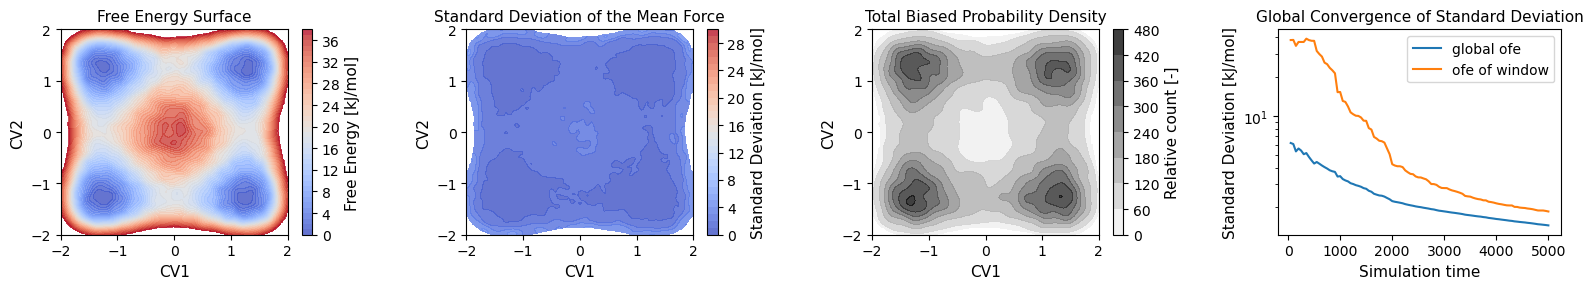

In [11]:
os.chdir(path_4W)

# #Run simulation
# run_plumed.run_langevin2D(1000000, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=2, biasfactor=20, gaus_pace=100, file_extension="_1M")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_1M")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_1M")

#Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], min_grid=[-2, -2], max_grid=[2, 2], 
                     error_pace = int(len(HILLS)/100), nhills=-1, window_corners=[-0.5, 0.5, -0.5, 0.5], FES_cutoff=38, use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=[-2, -2], max_grid=[2, 2])

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history, time_history, FES_lim=39, ofe_map_lim=31)
plt.plot(time_history, ofe_history_window, label="ofe of window")
plt.legend()
plt.show()

#rename results for later use
Force_terms_old = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]
ofe_history_old, ofe_history_window_old, time_history_old = ofe_history, ofe_history_window, time_history

#### (2) - Running 10 short simulations (each 1/10 the length of (1), and patch togehter with MFI)


Simulation: 0
|**************************************************| 100% | Average Mean Force Error: 47.252
Simulation: 1
|**************************************************| 100% | Average Mean Force Error: 37.872
Simulation: 2
|**************************************************| 100% | Average Mean Force Error: 32.95
Simulation: 3
|**************************************************| 100% | Average Mean Force Error: 29.706
Simulation: 4
|**************************************************| 100% | Average Mean Force Error: 27.611
Simulation: 5
|**************************************************| 100% | Average Mean Force Error: 26.373
Simulation: 6
|**************************************************| 100% | Average Mean Force Error: 24.805
Simulation: 7
|**************************************************| 100% | Average Mean Force Error: 23.709
Simulation: 8
|**************************************************| 100% | Average Mean Force Error: 23.125
Simulation: 9
|**********************

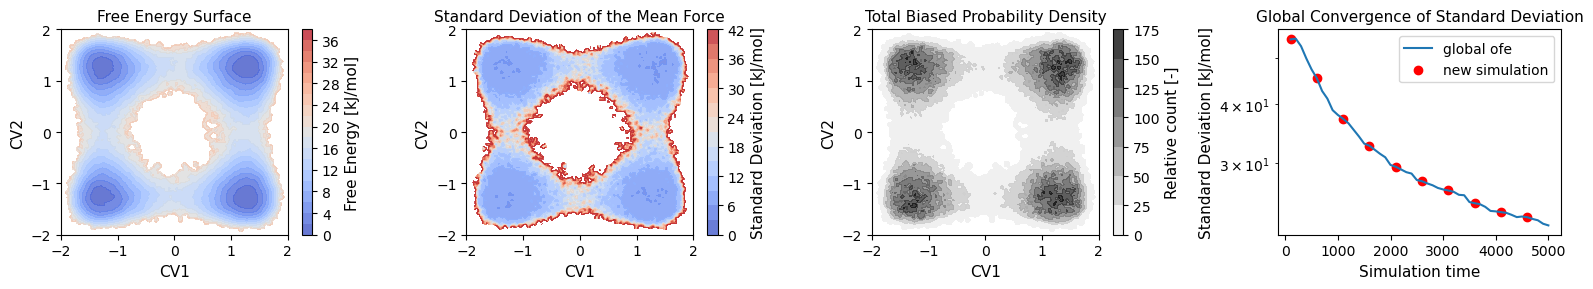

In [66]:
os.chdir(path_4W)

simulation_steps = 100000
n_simulations = 10
bw_short = [0.02, 0.02]
master = []
master_patch = [[ np.zeros_like(Force_terms_old[0]) for _ in range(6)]]
ofe_history_patch, ofe_history_patch_time = [0], [0]

for simulation in np.arange(0,n_simulations): 

    print('\nSimulation: '+str(simulation))
    file_extension="_s" + str(int(simulation))
    
    ###--- RUN short sim from random location
    # ipos=1.3*(2 * np.random.rand(2) - 1)
    # run_plumed.run_langevin2D(simulation_steps, initial_position_x=ipos[0], initial_position_y=ipos[1], gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=2, biasfactor=20, gaus_pace=100, file_extension=file_extension)

    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + file_extension)
    [position_x, position_y] = MFI.load_position_2D(position_name="position" + file_extension)

    #COMPUTE Mean force and weight of the simulation
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = bw_short, min_grid=[-2, -2], max_grid=[2, 2], 
                         error_pace = int(len(HILLS)/5), base_terms = master_patch[-1], FES_cutoff=38, use_weighted_st_dev=False)
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, valume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save ofe history
    ofe_history_patch += ofe_history
    ofe_history_patch_time += [element+ofe_history_patch_time[-1] for element in time_history]
    
#find variance and error map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5], use_weighted_st_dev=False)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)))

# cutoff = np.where(Ftot_den < 10**-5, 0, cutoff)

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
ofe_history_patch_time = ofe_history_patch_time[1:]
#make "sim_start" list with the first entry of each simulation
sim_start = [ofe_history_patch_time[int(i*len(ofe_history_patch_time)/n_simulations)] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[int(i*len(ofe_history_patch_time)/n_simulations)] for i in range(n_simulations)]

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(master_patch[-1][0]*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history_patch, ofe_history_patch_time, FES_lim=40, ofe_map_lim=int(ofe_history_patch[-1]*2), FES_step=2, ofe_step=3)
plt.scatter(sim_start, sim_start_error, c="r", label="new simulation")
plt.legend()
plt.show()

#### (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together

|**************************************************| 100% | Average Mean Force Error: 1.282

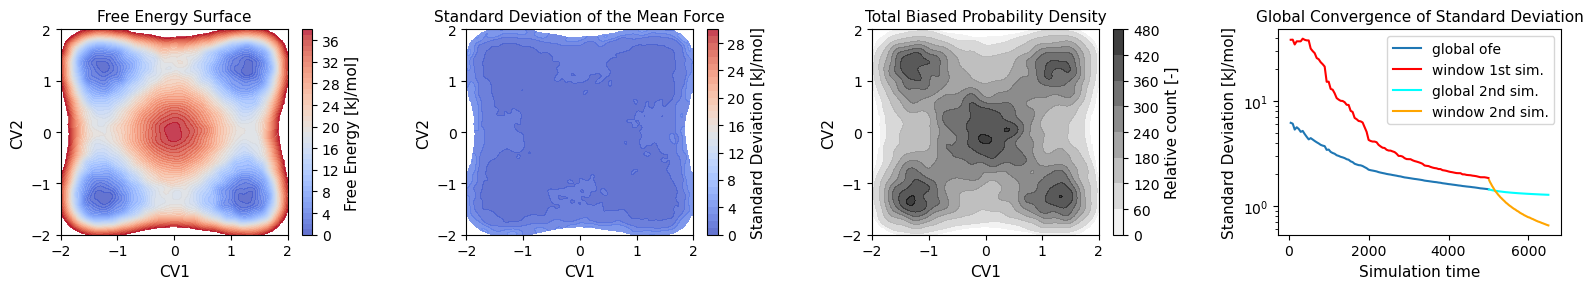

In [68]:
os.chdir(path_4W)
hp_centre, hp_kappa = [0.0, 0.0], [50, 50]

# #Run simulation with Harmonic potential
# run_plumed.run_langevin2D(300000, grid_min_x=-3.0, grid_max_x=3.0, grid_min_y=-3.0, grid_max_y=3.0, grid_bin_x=200, grid_bin_y=200, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=5, gaus_pace=100, hp_centre_x=hp_centre[0], hp_centre_y=hp_centre[1], hp_kappa_x=hp_kappa[0], hp_kappa_y=hp_kappa[1], file_extension="BjHP")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + "BjHP")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position" + "BjHP")

#Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, min_grid=[-2, -2], max_grid=[2, 2], bw = [0.1,0.1], 
                     error_pace = int(len(HILLS)/100), base_terms = Force_terms_old, window_corners=[-0.5, 0.5, -0.5, 0.5], FES_cutoff=38, 
                     hp_centre_x=hp_centre[0], hp_centre_y=hp_centre[1], hp_kappa_x=hp_kappa[0], hp_kappa_y=hp_kappa[1], use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

#Patch results
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y] = MFI.patch_2D([Force_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]])
ofe_history_time = [element+time_history_old[-1] for element in time_history]

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)))

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history_old, time_history_old, FES_lim=39, ofe_map_lim=31)
plt.plot(time_history_old, ofe_history_window_old, c="red", label="window 1st sim.")
plt.plot(ofe_history_time, ofe_history, c="cyan", label="global 2nd sim.")
plt.plot(ofe_history_time, ofe_history_window, c="orange", label="window 2nd sim.")
plt.legend()
plt.show()

## C: Invernizzi Potential | 2D non-periodic example

$z = 1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598$

#### (0) - Analytical plot

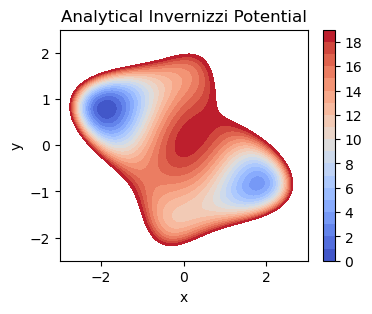

In [2]:
gridx, gridy = np.linspace(-3, 3, 200), np.linspace(-2.5, 2.5, 400); 
X, Y = np.meshgrid(gridx, gridy)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)

plt.figure(figsize=(4,3)); 
plt.contourf(X, Y, inve_pot, levels=range(0, 20, 1), cmap='coolwarm')
plt.xlabel("x"); plt.ylabel("y"); plt.title("Analytical Invernizzi Potential"); plt.colorbar(); plt.show()

#### (1) - Running a metadynamics simulation and analyse with MFI

|**************************************************| 100% | Average Mean Force Error: 1.429

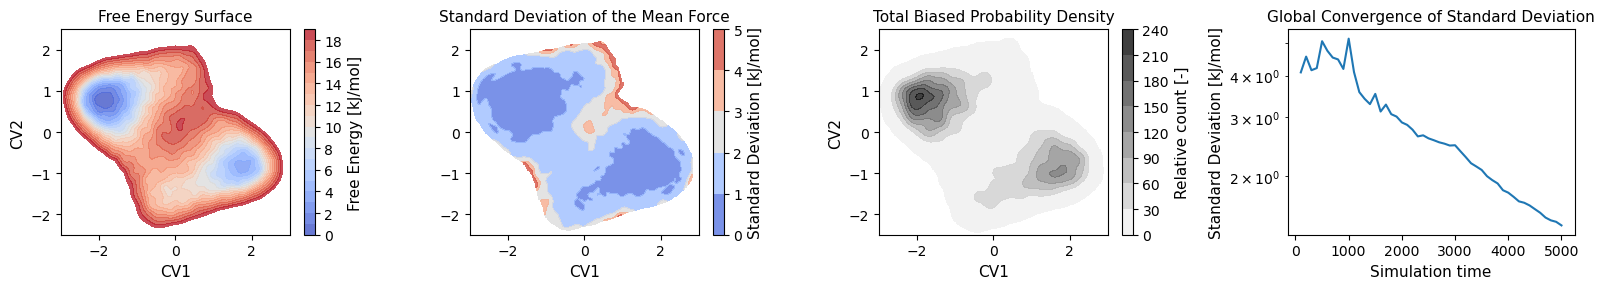

Final AAD_cut: 1.5413


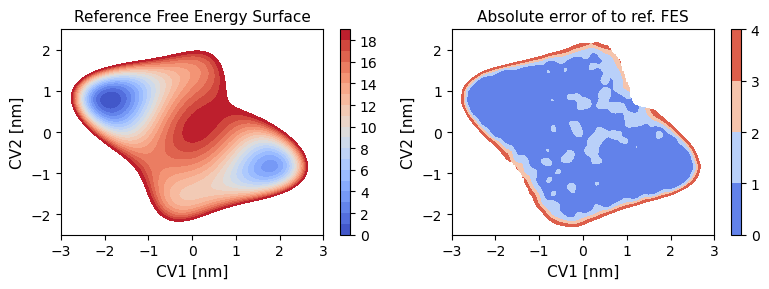

In [3]:
os.chdir(path_inve)
###--- Run simulation
# run_plumed.run_2D_Invernizzi(simulation_steps=2_000_000, sigma=0.1, height=1, biasfactor=10, initial_position_x=-1, initial_position_y=-1, file_extension="long")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_long")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_long")

#COMPUTE Mean force and weight of the simulation
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.12,0.12], nhills=int(len(HILLS)/2),
                    min_grid=[-3, -2.5], max_grid=[3, 2.5], nbins=[200,400], error_pace = int(len(HILLS)/100), FES_cutoff = 20, use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-3, -2.5)), max_grid=np.array((3, 2.5)))

#Plot results
MFI.plot_recap_2D(X, Y, FES, MFI.zero_to_nan(np.where(Ftot_den > 0.1, Ftot_den, 0)), MFI.zero_to_nan(ofe*cutoff), ofe_history, time_history, FES_lim=20, ofe_map_lim=6, FES_step=1, ofe_step=1)
plt.show()

AD = abs(inve_pot - FES)*cutoff
AAD = np.sum(AD) / np.count_nonzero(cutoff)
print("Final AAD_cut:", round(AAD, 4))

plt.figure(33, figsize=(8,3))
plt.subplot(1,2,1)
plt.contourf(X, Y, inve_pot, levels=range(0, 20, 1), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Reference Free Energy Surface', fontsize=11)

plt.subplot(1,2,2)
plt.contourf(X, Y, MFI.zero_to_nan(AD), levels=range(0, 5, 1), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Absolute error of to ref. FES', fontsize=11)
plt.tight_layout(); plt.show()

#### (2) - Running multiple short simulations, patch togehter with MFI, and determine bootstrap error


Simulation:  0    |   
Simulation:  1    |   
Simulation:  2    |   
Simulation:  3    |   
Simulation:  4    |   
Simulation:  5    |   
Simulation:  6    |   
Simulation:  7    |   
Simulation:  8    |   
Simulation:  9    |   
Simulation:  10    |   
Simulation:  11    |   
Simulation:  12    |   
Simulation:  13    |   
Simulation:  14    |   
Simulation:  15    |   
Simulation:  16    |   
Simulation:  17    |   
Simulation:  18    |   
Simulation:  19    |   

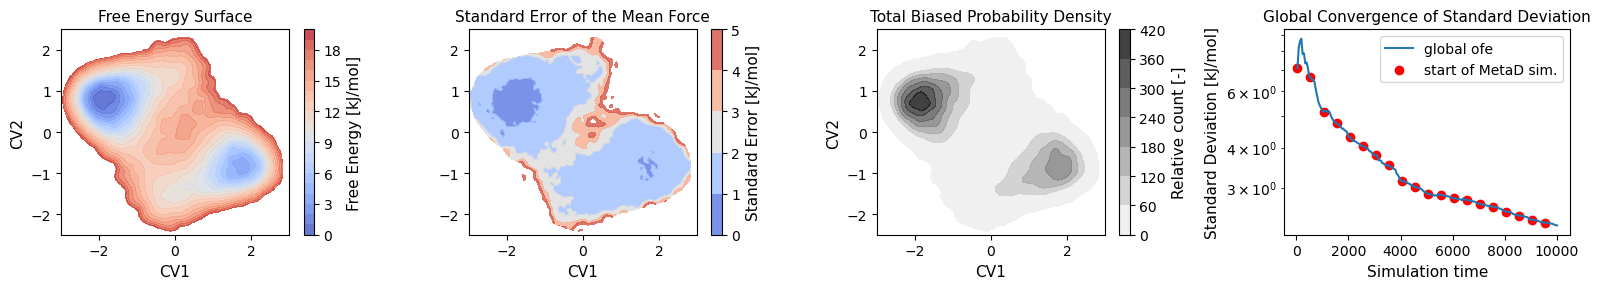

Final AAD_cut: 3.0024


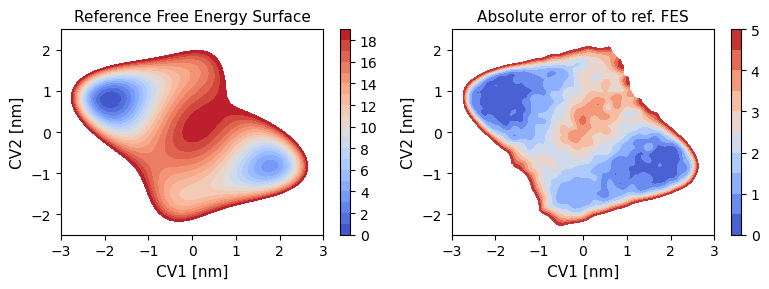

In [13]:
os.chdir(path_inve)

n_simulations = 20
forces_all = []
master = []
master_patch = [[ np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, time_history_patch = [0], [0]


for simulation in np.arange(0,n_simulations):   
    print("\nSimulation: ", simulation, "   |   " , end="")   
    
    #if forces are already computed, load them. Otherwise, run the simulation       
    if os.path.exists(path_inve + "/forces_inve_" + str(simulation)) == True:
        [Ftot_den, Ftot_x, Ftot_y, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.load_pkl(path_inve + "/forces_inve_" + str(simulation))
    else:
        ##--- Run simulation with random initial position (alternating between starting in the 1st and 2nd basin)
        # [initial_position_x, initial_position_y] = (-1)**simulation * 1.3 * np.random.rand() , -(-1)**simulation * 1.3 * np.random.rand() 
        # run_plumed.run_2D_Invernizzi(simulation_steps=100_000, sigma=0.1, height=5, biasfactor=10, initial_position_x=initial_position_x, initial_position_y=initial_position_y, file_extension=str(simulation))
                                             
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_"+str(simulation))
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_"+str(simulation))
        
        #COMPUTE Mean force and weight of the simulation
        results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], error_pace = int(len(HILLS)/10), 
                             base_terms = master_patch[-1], nhills=-1, min_grid=[-3, -2.5], max_grid=[3, 2.5], FES_cutoff = 20, use_weighted_st_dev=False)
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
        
        #save results
        MFI.save_pkl([Ftot_den, Ftot_x, Ftot_y, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y], path_inve + "/forces_inve_" + str(simulation))
        
    # store forces for bootstrap analysis     
    forces_all.append([Ftot_den, Ftot_x, Ftot_y])
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save ofe history and time
    ofe_history_patch += ofe_history
    time_history_patch += [element+time_history_patch[-1] for element in time_history]
    
    
#find variance and error map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5], use_weighted_st_dev=False)

#integration 
[X, Y, FES] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=[-3, -2.5], max_grid=[3, 2.5])

#get cutoff
cutoff = MFI.get_cutoff(Ftot_den=master_patch[-1][0], FX=master_patch[-1][2], FY=master_patch[-1][3], FES_cutoff=[20, [-3, -2.5], [3, 2.5], [0,0]]) # [Ftot_den, Ftot_x, Ftot_y, [FES_cutoff, min_grid, max_grid, periodic]]

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = [i for i in time_history_patch[1:]]
#make "sim_start" list with only the first entry of a simulation
sim_start = [time_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i*int(len(time_history_patch)/n_simulations)] for i in range(n_simulations)]


# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(master_patch[-1][0]*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history_patch, time_history_patch, FES_lim=21, ofe_map_lim=6, use_weighted_st_dev=False)
plt.scatter(sim_start, sim_start_error, c="r", label="start of MetaD sim.")
plt.legend()
plt.show()

AD = abs(inve_pot[::2,:] - FES)*cutoff
AAD = np.sum(AD) / np.count_nonzero(cutoff)
print("Final AAD_cut:", round(AAD, 4))

plt.figure(33, figsize=(8,3))
plt.subplot(1,2,1)
plt.contourf(X, Y, inve_pot[::2,:], levels=range(0, 20, 1), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Reference Free Energy Surface', fontsize=11)

plt.subplot(1,2,2)
plt.contourf(X, Y, MFI.zero_to_nan(AD), np.linspace(0, 5, 11), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Absolute error of to ref. FES', fontsize=11)
plt.tight_layout(); plt.show()

#### (2.1) - Bootstrap analysis

|**************************************************| 100% | Bootstrap Average Standard Deviation: 0.155
Time for bootstrap 14.582656383514404


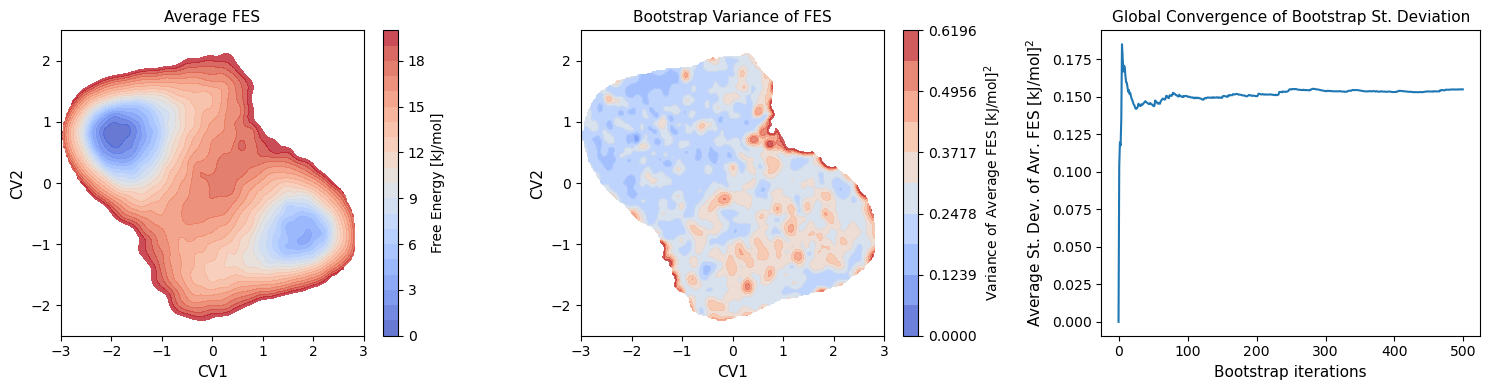

Final AAD_cut: 1.5023


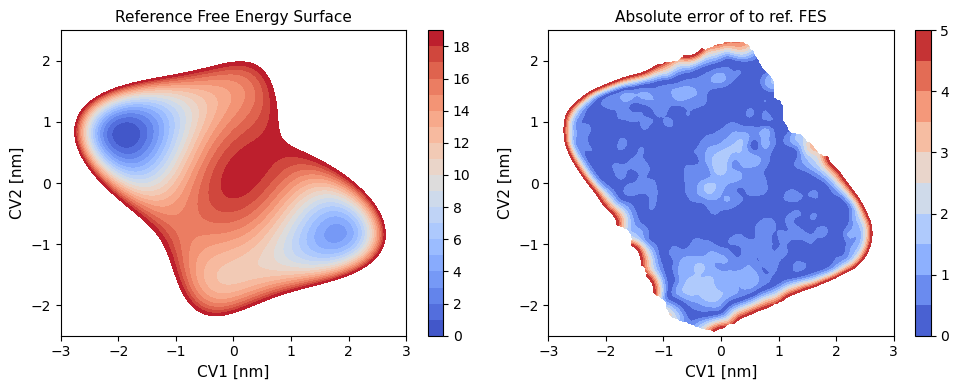

In [14]:
import time
start = time.time()
[FES_avr, sd_fes, sd_fes_prog ] = MFI.bootstrap_2D_new(X, Y, np.array(forces_all), n_bootstrap=500, FES_cutoff=20) 
print("\nTime for bootstrap", time.time() - start)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(FES_avr*cutoff), MFI.zero_to_nan(sd_fes*cutoff), sd_fes_prog, FES_lim=20, sd_lim=sd_fes_prog[-1]*4, sd_levels=11)
plt.tight_layout()
plt.show()

AD_FES_avr = abs(inve_pot[::2,:] - FES_avr)*cutoff
AAD_FES_avr = np.sum(AD_FES_avr) / np.count_nonzero(cutoff)
print("Final AAD_cut:", round(AAD_FES_avr, 4))

plt.figure(33, figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(X, Y, inve_pot[::2,:], levels=range(0, 20, 1), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Reference Free Energy Surface', fontsize=11)

plt.subplot(1,2,2)
plt.contourf(X, Y, MFI.zero_to_nan(AD_FES_avr*cutoff), levels=np.linspace(0,5,11), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Absolute error of to ref. FES', fontsize=11)
plt.tight_layout(); 
plt.show()


#### (3) Some short simulations with HP

~~~~~~~~~~ Load previous simulations ~~~~~~~~~~~

~~~~~~~~~~ HP simulations ~~~~~~~~~~~


Simulation:  0    |   
Simulation:  1    |   
Simulation:  2    |   
Simulation:  3    |   
Simulation:  4    |   
Simulation:  5    |   
Simulation:  6    |   
Simulation:  7    |   
Simulation:  8    |   
Simulation:  9    |   

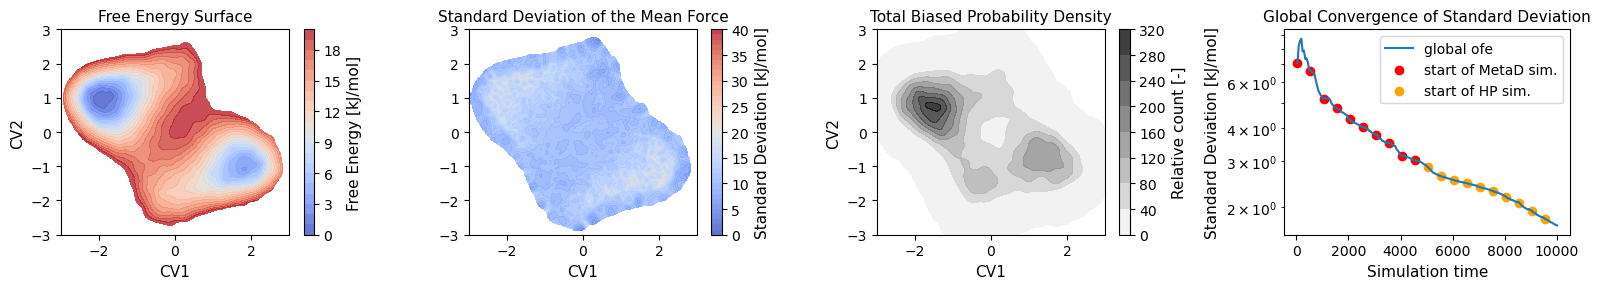

Final AD_cut: 1.5425


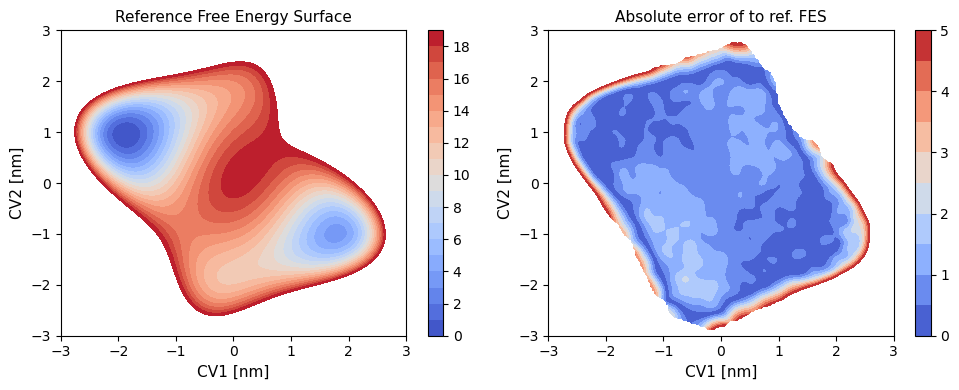

In [15]:
os.chdir(path_inve)
forces_all = []
master = []
master_patch = [[ np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, time_history_patch = [0], [0]

###--- Load the first 10 simulations from the previous 20 simulations
print("~~~~~~~~~~ Load previous simulations ~~~~~~~~~~~\n")
n_simulations = 10

for simulation in np.arange(0,n_simulations):   

    [Ftot_den, Ftot_x, Ftot_y, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.load_pkl(path_inve + "/forces_inve_" + str(simulation))

    forces_all.append([Ftot_den, Ftot_x, Ftot_y])
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    master_patch.append(MFI.patch_2D(master))
    ofe_history_patch += ofe_history
    time_history_patch += [element+time_history_patch[-1] for element in time_history]

print("~~~~~~~~~~ HP simulations ~~~~~~~~~~~\n")

d = 0.20
initial_positions = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  #AAD 1.19 k=35 d=0.2

initial_positions = [ [-1+0.2*i, -1+0.2*i] for i in range(10)]

kappa = 10
    
    
for simulation in np.arange(0,len(initial_positions)):   
    print("\nSimulation: ", simulation, "   |   " , end="")          
    if os.path.exists(path_inve + "/forces_inve_HP_" + str(simulation)) == True:
        [Ftot_den, Ftot_x, Ftot_y, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.load_pkl(path_inve + "/forces_inve_HP_" + str(simulation))
    else:    
        ##--- Run simulation with HP
        # run_plumed.run_2D_Invernizzi(simulation_steps=100000, sigma=0.1, height=1, biasfactor=10, initial_position_x=initial_positions[simulation][0], initial_position_y=initial_positions[simulation][1],
        #            hp_centre_x=initial_positions[simulation][0], hp_centre_y=initial_positions[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa, file_extension="HP_"+str(simulation))
                                             
        #Read the HILLS and position file
        HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_HP_"+str(simulation))
        [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_HP_"+str(simulation))
        
        results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], error_pace = int(len(HILLS)/10), 
                             base_terms = master_patch[-1], min_grid=[-3, -2.5], max_grid=[3, 2.5], FES_cutoff = 20, use_weighted_st_dev=False,
		                     hp_centre_x=initial_positions[simulation][0], hp_centre_y=initial_positions[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa)
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, _ , time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
  
		#save results
        MFI.save_pkl([Ftot_den, Ftot_x, Ftot_y, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y], path_inve + "/forces_inve_HP_" + str(simulation))
        
         
    forces_all.append([Ftot_den, Ftot_x, Ftot_y])
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    master_patch.append(MFI.patch_2D(master))
    ofe_history_patch += ofe_history
    time_history_patch += [element+time_history_patch[-1] for element in time_history]   

# Find variance and error map and integrate to get FES    
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5])
[X, Y, FES] = MFI.intgrad2(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))

#get cutoff
cutoff = MFI.get_cutoff(Ftot_den=master_patch[-1][0], FX=master_patch[-1][2], FY=master_patch[-1][3], FES_cutoff=[20, [-3, -2.5], [3, 2.5], [0,0]]) # [Ftot_den, Ftot_x, Ftot_y, [FES_cutoff, min_grid, max_grid, periodic]]

###--- Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = [i for i in time_history_patch[1:]]
sim_start = [time_history_patch[i*int(len(time_history_patch)/(n_simulations+len(initial_positions)))] for i in range(n_simulations+len(initial_positions))]
sim_start_error = [ofe_history_patch[i*int(len(time_history_patch)/(n_simulations+len(initial_positions)))] for i in range(n_simulations+len(initial_positions))]

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(master_patch[-1][0]), MFI.zero_to_nan(np.sqrt(ofv)*cutoff), ofe_history_patch, time_history_patch, FES_lim=21, ofe_map_lim=41)
plt.scatter(sim_start[:10], sim_start_error[:10], c="r", label="start of MetaD sim.")
plt.scatter(sim_start[10:], sim_start_error[10:], c="orange", label="start of HP sim.")
plt.legend()
plt.show()

AD = abs(inve_pot[::2,:] - FES)*cutoff
AAD = np.sum(AD) / np.count_nonzero(cutoff)
print("Final AD_cut:", round(AAD, 4))

plt.figure(33, figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(X, Y, inve_pot[::2,:], levels=range(0, 20, 1), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Reference Free Energy Surface', fontsize=11)

plt.subplot(1,2,2)
plt.contourf(X, Y, MFI.zero_to_nan(AD), levels=np.linspace(0, 5, 11), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Absolute error of to ref. FES', fontsize=11)

plt.tight_layout(); plt.show()


Text(0.5, 1.0, 'US Trajectories and position of HP')

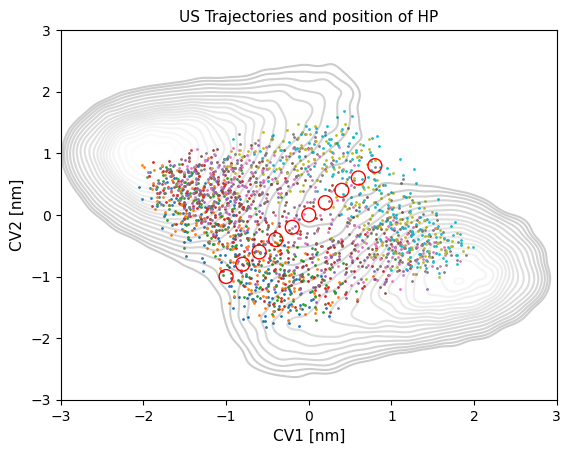

In [9]:
for i in range(10):
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_HP_"+str(i))
    plt.scatter(HILLS[:,1], HILLS[:,2], label="HILLS", s=1)
plt.contour(X,Y, FES, levels=range(0, 20, 1), cmap='binary', alpha=0.2)

initial_positions = [ [-1+0.2*i, -1+0.2*i] for i in range(10)]
for i in range(len(initial_positions)): plt.scatter(initial_positions[i][0], initial_positions[i][1], facecolors='none', edgecolors="red", s=100)
plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.xlabel('CV1 [nm]', fontsize=11); plt.ylabel('CV2 [nm]', fontsize=11); plt.title('US Trajectories and position of HP', fontsize=11)


#### (3.1) - Bootstrap analysis

|**************************************************| 100% | Bootstrap Average Standard Deviation: 0.202
Time for bootstrap 14.16970443725586


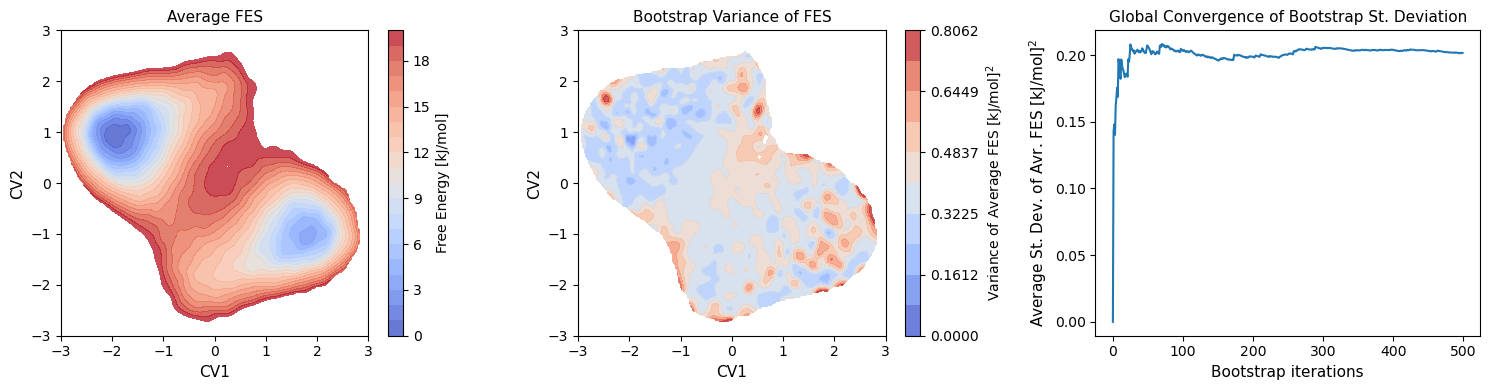

Final AAD_cut: 1.5794


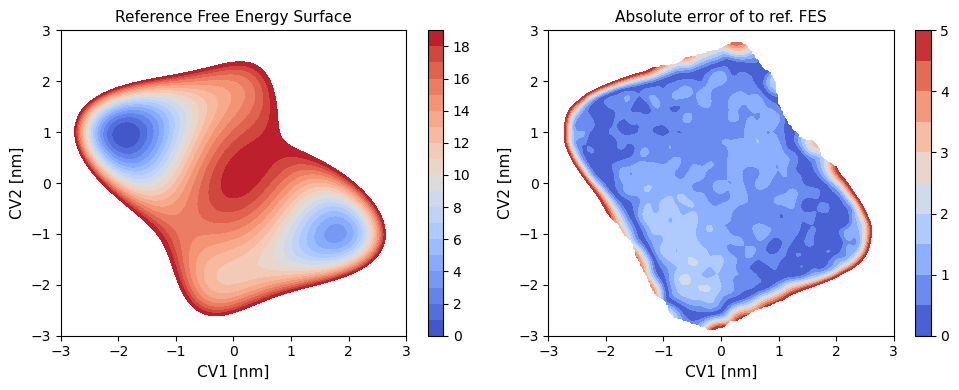

In [16]:
import time
start = time.time()
[FES_avr, sd_fes, sd_fes_prog ] = MFI.bootstrap_2D_new(X, Y, np.array(forces_all), n_bootstrap=500, FES_cutoff=20) 
print("\nTime for bootstrap", time.time() - start)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(FES_avr*cutoff), MFI.zero_to_nan(sd_fes*cutoff), sd_fes_prog, FES_lim=20, sd_lim=sd_fes_prog[-1]*4, sd_levels=11)
plt.tight_layout()
plt.show()

AD_FES_avr = abs(inve_pot[::2,:] - FES_avr)*cutoff
AAD_FES_avr = np.sum(AD_FES_avr) / np.count_nonzero(cutoff)
print("Final AAD_cut:", round(AAD_FES_avr, 4))

plt.figure(33, figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(X, Y, inve_pot[::2,:], levels=range(0, 20, 1), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Reference Free Energy Surface', fontsize=11)

plt.subplot(1,2,2)
plt.contourf(X, Y, MFI.zero_to_nan(AD_FES_avr*cutoff), levels=np.linspace(0, 5, 11), cmap='coolwarm')
plt.colorbar(); plt.xlim(np.min(X),np.max(X)); plt.ylim(np.min(Y),np.max(Y))
plt.ylabel('CV2 [nm]', fontsize=11); plt.xlabel('CV1 [nm]', fontsize=11); plt.title('Absolute error of to ref. FES', fontsize=11)
plt.tight_layout(); 
plt.show()
